Copyright 2021 The TensorFlow Similarity Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from collections import defaultdict
import gc
import os

import numpy as np

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [4]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [5]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SimSiamLoss
from tensorflow_similarity.losses import SimCLRLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [6]:
tfsim.utils.tf_cap_memory() # Avoid GPU memory blow up

2021-10-24 04:36:57.803234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:36:57.812087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:36:57.812691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
tf.keras.backend.clear_session() 
gc.collect()

0

# Dataset

## Loading

In [8]:
(x_train, y_raw_train), (x_test, y_raw_test) = keras.datasets.cifar100.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_raw_train, 100)
y_test = keras.utils.to_categorical(y_raw_test, 100)
print("y_train", y_train.shape, "y_test", y_test.shape)

x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 100) y_test (10000, 100)


In [9]:
IMG_SIZE = 32
BATCH_SIZE = 64


LR = 0.05
INIT_LR = LR * BATCH_SIZE / 256.0
PRE_TRAIN_EPOCHS = 5 # 100
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

In [10]:
train_augmenter = SimCLRAugmenter(IMG_SIZE, IMG_SIZE, is_training=True)
#     #test_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=False)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 64 (64 classes * 1 examples per class) with 2 augmenters


2021-10-24 04:37:03.232367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-24 04:37:03.233744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:37:03.234554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 04:37:03.235127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2021-10-24 04:37:05.219630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


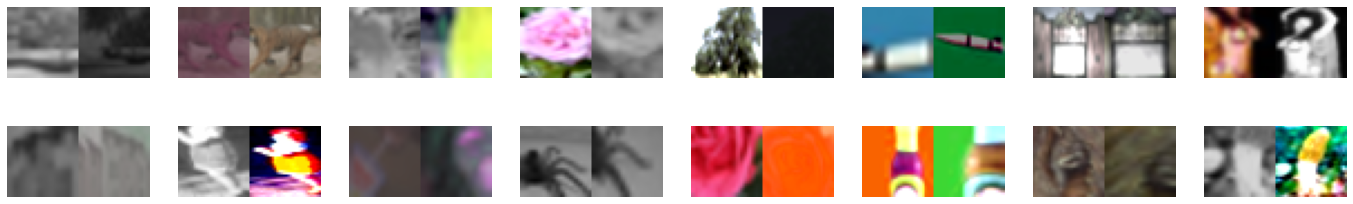

In [11]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## Backbone 

In [55]:
def get_encoder(IMG_SIZE, dim=2048, activation='relu', trainable=True):
    base_model = tf.keras.applications.ResNet50V2(include_top=False,
        weights=None, input_shape=(224, 224, 3))
    base_model.trainable = trainable

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = tf.image.resize(inputs, (224, 224))
    # ResNet expects [-1,1], but our augmented images are [0,1]
    x = layers.Rescaling(scale=2, offset=-1)(x)
    x = base_model(x, training=trainable)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x) # <- this blows up around 120 epochs
    
    # Projection Head
    x = layers.Dense(dim, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    x = layers.Dense(dim, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    x = layers.Dense(dim, use_bias=False)(x)
    o = layers.BatchNormalization()(x)

    backbone = Model(inputs, o, name='encoder')
    return backbone

encoder = get_encoder(IMG_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.image.resize_9 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
backbone_pool (GlobalAverage (None, 2048)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 2048)              4194304   
_________________________________________________________________
batch_normalization_37 (Batc (None, 2048)              8192

## Predictor model

In [56]:
def get_predictor(dim, hiddin_dim=512, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    
    x = layers.Dense(hiddin_dim, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation=activation)(x)
    
    o = layers.Dense(dim)(x)
    projector = Model(inputs, o, name="predictor")
    return projector

predictor = get_predictor(2048)
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               1048576   
_________________________________________________________________
batch_normalization_40 (Batc (None, 512)               2048      
_________________________________________________________________
activation_21 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 2048)              1050624   
Total params: 2,101,248
Trainable params: 2,100,224
Non-trainable params: 1,024
_________________________________________________________________


# Loss

In [57]:
# This loss is minimizing either the cosine distance or the angular 
# distance and should be between [0, 4]
loss = SimSiamLoss
metrics = [[encoder_std], []]

# Pre Training

In [ ]:
contrastive_model = ContrastiveModel(
    encoder_model=encoder, 
    projector_model=predictor, 
    swap_representation=True)

# use sgd as optimizer with constant loss as recommende in the paper.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=INIT_LR, decay_steps=PRE_TRAIN_EPOCHS * STEPS_PER_EPOCH
)
sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9)
contrastive_model.compile(optimizer=sgd, loss=loss, metrics=metrics)
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS)

Epoch 1/5
 53/781 [=>............................] - ETA: 3:47 - loss: 1.8552 - output_1_encoder_std: 0.0221

# Evaluation

In [ ]:
from tensorflow_similarity.samplers import select_examples

# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = select_examples(x_train, y_raw_train, num_examples_per_class=100)
y_restricted = keras.utils.to_categorical(y_restricted, 100)

TEST_EPOCHS = 20
TEST_STEPS_PER_EPOCH = len(x_restricted) // BATCH_SIZE

In [ ]:
def get_model(IMG_SIZE, encoder, LR):
    encoder.trainable = False
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = encoder(inputs, training=False)
    o = layers.Dense(100, activation='softmax')(x)
    model = Model(inputs, o, name='no_pretrain')
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=LR, decay_steps=TEST_EPOCHS * TEST_STEPS_PER_EPOCH
    )
    sgd = tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])
    return model

# No pretrain

In [ ]:
encoder = get_model(IMG_SIZE)
no_pt_decoder = Model(
    encoder.input, encoder.get_layer("backbone_pool").output
)
reg_model = get_model(IMG_SIZE, no_pt_decoder, LR)
reg_history = reg_model.fit(x_restricted, y_restricted, batch_size=BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

# Pretrained with SiamSiam

In [ ]:
contrastive_model.projector.summary()

In [ ]:
# encoder = contrastive_model.get_encoder()
# Extract the backbone ResNet20.
pt_encoder = Model(
    contrastive_model.encoder.input, contrastive_model.encoder.get_layer("backbone_pool").output
)
model2 = get_model(IMG_SIZE, pt_encoder, LR)
model2.summary()

In [ ]:
pre_history = model2.fit(x_restricted, y_restricted, batch_size=BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

In [ ]:
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))